In [1]:
cd ..

C:\Users\johan\github\designresolver


In [2]:
from collections import OrderedDict
from graphutils import draw_graph_graphical_props, flat_graph_formulation, Node, COMP, VAR
import matplotlib
from execution import Component
from workflow import get_f, generate_workflow
from assembly import build_archi
from executeformulations import extractvals

In [3]:
Ein = {
    1: (2,3),
    2: (1,)
}
Eout = {
    1: (None,),
    2: (None,),
}
Rin = {
    1: (1,),
    2: (2,),
}
Ftree = OrderedDict((
    (1,1),
    (2,1)
))
Stree = {}
Vtree = {1:1,2:1} #cannot have implicit components without solvefors
edges = Ein, Eout, Rin
tree = Ftree,Stree,Vtree

In [4]:
G = flat_graph_formulation(Ein, Eout, Rin)

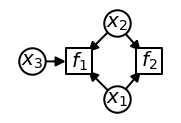

In [5]:
draw_graph_graphical_props(G, prog='sfdp', figsize=(3,2))

In [6]:
arg_mapping={1:'x_1',2:'x_2',3:'x_3'}
c1 = Component(lambda y,a: y**2+a, (2,3), (1,), 1, arg_mapping=arg_mapping)
c2 = Component(lambda x: x-1, (1,), (2,), 2, arg_mapping=arg_mapping)
c1r = Component(lambda x,y,a: -x+y**2+a, (1,2,3), None, 1, arg_mapping=arg_mapping)
c2r = Component(lambda x,y: -y+x-1, (1,2), None, 2, arg_mapping=arg_mapping)
components = [c1,c2,c1r,c2r]

In [7]:
c1r.graddict({'x_1':1, 'x_2':2, 'x_3':2})

{'x_1': array(-1.), 'x_2': array(4.), 'x_3': array(1.)}

In [8]:
lookup_f = get_f(components, edges)
workflow = generate_workflow(lookup_f, edges, tree, debug=False)

In [9]:
workflow

[(SOLVE, None, 's_1', {}),
 (IMPL,
  's_1',
  'res_f1_f2',
  [(['x_1', 'x_2', 'x_3'],
    ['x_1'],
    <bound method Component.evaldict of ((1, 2, 3), 1, (None,), 'None')>,
    <bound method Component.graddict of ((1, 2, 3), 1, (None,), 'None')>,
    1.0),
   (['x_1', 'x_2'],
    ['x_2'],
    <bound method Component.evaldict of ((1, 2), 2, (None,), 'None')>,
    <bound method Component.graddict of ((1, 2), 2, (None,), 'None')>,
    1.0)])]

In [10]:
prob, mdao_in, groups = build_archi(edges, tree, workflow)

In [11]:
prob.get_val('x_3')

array([0.22199317])

In [12]:
#prob.set_val('x_1',2)
#prob.set_val('x_1',2)
prob.set_val('x_3',.1)

In [13]:
prob.run_model()


===
s_1
===
NL: Newton Converged in 5 iterations


In [14]:
outs = extractvals(prob, {Node('x_1',VAR),Node('x_2',VAR),Node('x_3',VAR)})

In [15]:
outs

{'x_1': 2.5723805294763804, 'x_3': 0.1, 'x_2': 1.5723805294763802}

In [55]:
outs

{'x_1': 0.42761947052363924, 'x_2': -0.5723805294763608, 'x_3': 0.1}

In [56]:
[elt.evaldict(outs) for elt in components]

[0.42761947052363913, -0.5723805294763608]

In [16]:
[elt.evaldict(outs) for elt in components]

[2.5723805294764217,
 1.5723805294763804,
 4.1217029789208937e-14,
 2.220446049250313e-16]

# Mini-polynomials

In [3]:
from polycasebuilder import generate_random_prob, generate_random_polynomials, get_arg_mapping, eqv_to_edges_tree

In [26]:
n_eqs = 4
n_vars = 7
seed = 40#8 is triang#seed 10 is nice
sparsity = 1.1#0.8 1.1 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
#polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, dout, n_eqs)
#symb_mapping = get_arg_mapping(var_mapping, symbol_map=True)

In [27]:
polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, dout, n_eqs)

In [28]:
output_set = dout
output_set = {key:var-n_eqs for key,var in output_set.items()}
edges, tree= eqv_to_edges_tree(eqv, output_set, n_eqs)

### Create an executable formulation

In [29]:
from operators import sort_scc, reorder_merge_solve

In [30]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [31]:
nedges

({0: (1, 5), 1: (0, 6), 2: (1, 2), 3: (2, 3)},
 {3: (None,), 1: (None,), 2: (None,), 0: (None,)},
 {3: (0,), 2: (3,), 0: (6,), 1: (1,)})

In [32]:
ntree

(OrderedDict([(3, 2), (2, 2), (0, 2), (1, 2)]),
 {2: 1},
 {0: 2, 3: 2, 6: 2, 1: 2})

In [33]:
components

[((6, 5, 1), 0, (None,), '0.6*x_1*x_5*x_6 + 0.4'),
 ((6, 0, 1), 1, (None,), '-0.3*x_0*x_1 + 0.2*x_6 - 0.6'),
 ((2, 3, 1), 2, (None,), '-0.5*x_1*x_2*x_3 + 0.9'),
 ((2, 0, 3), 3, (None,), '-0.8*x_0*x_2*x_3 - 0.1'),
 ((5, 1), 0, (6,), '-0.666666666666667/(x_1*x_5)'),
 ((6, 0), 1, (1,), '(0.666666666666667*x_6 - 2.0)/x_0'),
 ((2, 1), 2, (3,), '1.8/(x_1*x_2)'),
 ((2, 3), 3, (0,), '-0.125/(x_2*x_3)')]

### Build workflow

In [34]:
lookup_f = get_f(components, nedges) #interesting what happens if we put in the wrong edges
workflow = generate_workflow(lookup_f, nedges, ntree, {2: {'maxiter':100}})

In [35]:
workflow

[(SOLVE, None, 's_1', {}),
 (SOLVE, 's_1', 's_2', {'maxiter': 100}),
 (IMPL,
  's_2',
  'res_f3_f2_f0_f1',
  [(['x_2', 'x_0', 'x_3'],
    ['x_0'],
    <bound method Component.evaldict of ((2, 0, 3), 3, (None,), '-0.8*x_0*x_2*x_3 - 0.1')>,
    <bound method Component.graddict of ((2, 0, 3), 3, (None,), '-0.8*x_0*x_2*x_3 - 0.1')>,
    1.0),
   (['x_2', 'x_3', 'x_1'],
    ['x_3'],
    <bound method Component.evaldict of ((2, 3, 1), 2, (None,), '-0.5*x_1*x_2*x_3 + 0.9')>,
    <bound method Component.graddict of ((2, 3, 1), 2, (None,), '-0.5*x_1*x_2*x_3 + 0.9')>,
    1.0),
   (['x_6', 'x_5', 'x_1'],
    ['x_6'],
    <bound method Component.evaldict of ((6, 5, 1), 0, (None,), '0.6*x_1*x_5*x_6 + 0.4')>,
    <bound method Component.graddict of ((6, 5, 1), 0, (None,), '0.6*x_1*x_5*x_6 + 0.4')>,
    1.0),
   (['x_6', 'x_0', 'x_1'],
    ['x_1'],
    <bound method Component.evaldict of ((6, 0, 1), 1, (None,), '-0.3*x_0*x_1 + 0.2*x_6 - 0.6')>,
    <bound method Component.graddict of ((6, 0, 1), 1, 

In [36]:
prob, mdao_in, groups = build_archi(nedges, ntree, workflow)

In [37]:
mdao_in

{'x_2', 'x_5'}

In [38]:
prob.set_val('x_1',0.1)

In [39]:
prob.run_model()


===
s_1
===
+  
+  =======
+  s_1.s_2
+  =======
+  NL: Newton Converged in 15 iterations
NL: Newton Converged in 0 iterations


# Check results

In [40]:
from graphutils import all_variables,edges_to_Ein_Eout

In [41]:
outs = extractvals(prob, {Node('x_{}'.format(elt),VAR) for elt in all_variables(*edges_to_Ein_Eout(edges))})

In [42]:
outs

{'x_6': 0.6295297437474326,
 'x_0': 0.33127630966502636,
 'x_5': 0.22199317108973948,
 'x_1': -4.770378859157984,
 'x_2': 0.8707323061773764,
 'x_3': -0.4333461827699808}

In [35]:
components

[((2, 3, 4, 1), 0, (None,), '0.6*x_1*x_3 + 0.4*x_2*x_4 - 0.2'),
 ((2, 3), 1, (None,), '0.2*x_2*x_3 - 0.6'),
 ((0,), 2, (None,), '0.3*x_0 + 0.9'),
 ((2, 3, 1), 0, (4,), '(-1.5*x_1*x_3 + 0.5)/x_2'),
 ((2,), 1, (3,), '3.0/x_2'),
 ((), 2, (0,), '-3.00000000000000')]

In [43]:
[elt.evaldict(outs) for elt in components]

[9.00612917575927e-13,
 -7.388534228880417e-13,
 2.0303758674344863e-12,
 1.6005252678752413e-13,
 [0.6295297437488503],
 [-4.770378859165418],
 [-0.43334618277095843],
 [0.33127630966449617]]